In [15]:
"""
regression_data_setup

The module set up data for regressions.

The data processings includes handling NA, new features, deflation, transformations.
"""

'\nregression_data_setup\n\nThe module set up data for regressions.\n\nThe data processings includes handling NA, new features, deflation, transformations.\n'

In [16]:
# for jupyter notebook
from pathlib import Path
import sys
import os

sys.path.insert(0, str(Path().resolve().parents[0].parents[0]))


In [17]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.utils import resample
from scipy import stats

In [18]:
from src.config import *

from src.data_transformation.pipeline import (
    get_performance_credit_panel_data, 
    get_performance_credit_panel_data_2014, 
    get_performance_credit_relationship_panel_data
)

In [19]:
# Chinese
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns; sns.set()

#%matplotlib inline

font_path = os.path.join(data_path, 'simsun.ttc')
prop = fm.FontProperties(fname=font_path)

plt.rcParams["font.sans-serif"]=["simsun"] 
plt.rcParams["axes.unicode_minus"]=False

# Regression Data Setup

In [20]:
# auxilury functions
def normal_with_negative(df):
    """
    Normolize the dataframe by considering sign and absolute max boundry.
    
    Parameters
    ----------
    df : DataFrame
        
    Returns
    ----------
    DataFrame
    """
    # norm data to -1 to 1 with border equals to s_abs_max
    s_max = df.max()
    s_min = df.min().abs()

    s_abs_max = pd.Series(np.where(s_max>s_min, s_max, s_min), s_max.index)

    df_normed = df / s_abs_max
    
    return df_normed


def add_window_credit(data, credit_cols, periods=1):
    """
    Add credit category from last periods years.
    
    Parameters
    ----------
    data : DataFrame
    credit_cols: list of str
        The list item is the credit column name, like 'red', 'green', and 'black'.
    periods : int, default 1
        The last years to generate.
        
    Returns
    ----------
    DataFrame
    """
    # periods can by 1 or 2 only
    data = data.join(data[credit_cols].shift(1).add_suffix('_i_1'))
    
    if periods == 2:
        data = data.join(data[credit_cols].shift(2).add_suffix('_i_2'))
    
    return data


def combine_credit_columns_into_one(data):
    """
    Add new column 'credit' by setting black to 0, green to 1, and red to 2.
    
    Parameters
    ----------
    df : DataFrame
        
    Returns
    ----------
    DataFrame
    """
    # add new column: ordered credit red:2, green:1, black: 0
    
    data['credit'] = data['green']
    data.loc[data.red==1, 'credit'] = 2
    data.loc[data.black==1, 'credit'] = 0
    
    #data = data.drop(credit_cols, axis=1)

    print(data.credit.value_counts())
    
    return data


# do not need, stata handle dummy
def handle_fe(data):
    """
    Dummyize fixed effect columns.
    
    Parameters
    ----------
    df : DataFrame
        
    Returns
    ----------
    DataFrame
    """
    # add FE for year, industry, and province          
    data = pd.get_dummies(
        data, 
        columns=fe_cols[:-1],
        prefix=fe_cols[:-1],
        drop_first=True
    )
    
    # handle organ type(multi values) separately
    data = data.join(
        data.organ_type_code.str.get_dummies(sep=',').add_prefix('organ_') # drop the first column
    ).drop(['organ_type_code', 'organ_2', 'IndustryCode_C39', 'province_con_浙江'], axis=1)  
    
    return data

def binarize_data(data):
    """
    Binarize data in the dataframe.
    
    Parameters
    ----------
    df : DataFrame
        
    Returns
    ----------
    DataFrame
    """
    data[data>1] = 1
    data[data<1] = 0
    
    return data

def get_data_after_2014(data, credit_col='red'):
    """
    Get data after 2014.
    
    Parameters
    ----------
    df : DataFrame
        
    Returns
    ----------
    DataFrame
    """
    # credit_col can be 'credit'
    return data[data[credit_col].notnull()]


def remove_inf_data(data):
    """
    Move infinity from dataframe.
    
    Parameters
    ----------
    df : DataFrame
        
    Returns
    ----------
    DataFrame
    """
    return data.replace([np.inf, -np.inf], np.nan)


def show_distributions(data, cols):
    """
    Show distribution of cols in dataframe to see if stardarization is possible.
    
    Parameters
    ----------
    df : DataFrame
    cols : list of str
        
    Returns
    ----------
    DataFrame
    """
    for col in cols:
        print(stats.normaltest(data[col].replace([np.inf, -np.inf], np.nan)))
        try:
            plt.hist(data[col])
            plt.title(col)
            plt.show()
            plt.cla()
        except:
            print(data[col].replace([np.inf, -np.inf], np.nan))

In [21]:
def check_year_continuity(df_cp):
    """
    Check if the years in a firm is consecutive.
    
    Parameters
    ----------
    df : DataFrame
    """
    # there should be no gap year
    df_index = df_cp.index.to_frame().reset_index(drop=True)

    df_index['year_diff'] = df_index.groupby('company_name')['year'].shift(1)
    df_index['year_diff'] = df_index.year-df_index.year_diff

    print('if the results only contains 1, that means Years are consecutive for each company')
    print(df_index.year_diff.value_counts())

In [22]:
# FE columns can not have NA : 
# organ_type: remove 224 row, 59 companies
# IndustryName(24 company & row :astablish from 2020 and 2020 no data)
# province_con: 134 companies, 578 row
def check_dummy_na_state(df_cp):
    """
    Check if the columns have missing data.
    
    Parameters
    ----------
    df : DataFrame
    """
    for check_na_col in ['organ_type', 'IndustryName', 'province_con']:
        col_index = df_cp.columns.get_loc(check_na_col)


        df_na = df_cp[df_cp[check_na_col].isna()]
        print(df_na.shape)
        display(df_na.head(10))

        # look into from whole list
        id_list = df_na.index.get_level_values('ID').unique().tolist()
        print(f'company numbers: {len(id_list)}')
        df_cp.iloc[df_cp.index.get_level_values('ID').isin(id_list), col_index].value_counts() # if [] -> all company has no value
        

def print_dataset_size(data):
    """
    Print dataset size with the number of firms and observations.
    
    Parameters
    ----------
    df : DataFrame
    """
    company_number = len(data.index.get_level_values('ID').unique())
    
    print(f'rows:{data.shape[0]}; companies: {company_number}')

def remove_rows_with_na_dummy(data, dummy_cols):
    """
    Remove observations with missing data in dummy columns.
    
    If more than one observations in a firm are found, all the observations of the firm will be removed.
    
    Parameters
    ----------
    df : DataFrame
    dummy_cols : list of str
        The value normally are ['province', 'industry', 'year', 'organ_type']
        
    Returns
    ----------
    DataFrame
    """
    df = data.copy()
    print('original size:')
    print_dataset_size(data)
    
    for col in dummy_cols:
        # get na rows and compnies
        df_na = df[df[col].isna()]
        company_id_list = df_na.index.get_level_values('ID').unique().tolist()
        print(f'drop: companies-{len(company_id_list)}; rows-{df_na.shape[0]}')
        
        # remove rows by company
        df = df[~df.index.get_level_values('ID').isin(company_id_list)]
    
    print('processed size after removing dummy NA:')
    print_dataset_size(df)
    
    return df

In [23]:
import random

def sample_df(df_cp, n=1000):
    """
    Sample the regression data.
    
    Parameters
    ----------
    df : DataFrame
    n : int
        Sample size.
        
    Returns
    ----------
    DataFrame
    """
    # sample data by company
    # company with black->keep all the companies in black
    df_group = df_cp.reset_index().groupby('company_name')
    df_black_company = df_group.sum()
    black_companies = df_black_company[df_black_company.black > 0].index.tolist()
    df_black_company = df_cp[df_cp.index.get_level_values('company_name').isin(black_companies)]

    # for other companies-> sample random 1000 companies
    other_companies = list(set(df_cp.index.get_level_values('company_name').tolist()) - set(black_companies))
    sample_companies = random.sample(other_companies, n)
    print(len(sample_companies))

    df_sample_company = df_cp[df_cp.index.get_level_values('company_name').isin(sample_companies)]

    df_sample = pd.concat([df_black_company, df_sample_company])

    return df_sample

def save_stata_data(df, file_name):
    """
    Save dataframe to stata format.
    
    Parameters
    ----------
    df : DataFrame
    file_name : str
    """
    df.to_stata(os.path.join(processed_data_path, 'regression_data', file_name), version=118)

In [24]:
# handle column names   
def get_new_column_names(cols, prefix):
    """
    Provide column names for transformed columns.
    
    Parameters
    ----------
    cols : list of str
        The original list of columns.
    prefix : str
        The prefix to add to the cols.
        
    Returns
    ----------
    list of str
    """
    return [prefix + c for c in cols]

monetary_cols = ['subsidy', 'RD', 'TotalAssets', 'TotalLiability', 'IntangibleAsset',
                   'ProfitParent', 'NetProfit', 'OperatingEvenue', 'OperatingCost',
                   'OperationProfit', 
                ]

real_mon_cols = get_new_column_names(monetary_cols, 'real_')

scale_cols = ['patents_apply', 'patents_grant', 'employee', 
              'age', 'ROA', 'op_profit_margin', 'asset_turnover', 'labour_productivity'] + monetary_cols

In [29]:
def get_ever_credit_feature(df, credit_col):
    """
    Get new credit feature.
    
    Parameters
    ----------
    df : DataFrame
    credit_col : str
        'red' or 'black'
        
    Returns
    ----------
    seires
    """
    s_cum = df.groupby(level='company_name')[credit_col].aggregate(np.cumsum)
    s_cum = s_cum - df[credit_col]

    return s_cum.apply(lambda x: 1 if x > 0 else x)


def add_new_features(df_cp):
    """
    Add new features labour_productivity, ever_red, ever_black, ever_red_daughters, ever_black_daughters.
    
    Parameters
    ----------
    df_cp : DataFrame
        
    Returns
    ----------
    DataFrame
    """
    df_cp['labour_productivity'] = df_cp.OperatingEvenue / df_cp.employee
    
    df_cp.reset_index().groupby('company_name')['red']
    df_cp['ever_red'] = get_ever_credit_feature(df_cp, 'red')
    df_cp['ever_black'] = get_ever_credit_feature(df_cp, 'black')
    
    df_cp['ever_red_daughters'] = get_ever_credit_feature(df_cp, 'red_daughters')
    df_cp['ever_black_daughters'] = get_ever_credit_feature(df_cp, 'black_daughters')
    
    return df_cp

In [26]:
def get_panel_without_na_dummy(with_relationship=False):
    """
    Return pre-processed panel data.
    
    Parameters
    ----------
    with_relationship : bool, default False
        If the original data contains relationship data.
        
    Returns
    ----------
    DataFrame
    """
    #df_cp = get_performance_credit_panel_data_2014()
    # get original panel data
    df_cp = None
    
    if with_relationship:
        df_cp = get_performance_credit_relationship_panel_data()
    else:
        df_cp = get_performance_credit_panel_data()
    
    # only years from 2014 to 2020
    df_cp = df_cp[(df_cp.index.get_level_values('year') <= 2020) & (df_cp.index.get_level_values('year') >= 2012)]
    print('original size')
    print_dataset_size(df_cp)
    
    print('remove rows without totalassets')
    df_cp = df_cp[df_cp.TotalAssets.notna()]
    
    # missing data processing: imputation or delete
    print('handle dummies with missing values')
    df_cp = df_cp.pipe(remove_rows_with_na_dummy, ['organ_type', 'IndustryName', 'province_con'])
    
    # handle organ_type: SOE: 1, others:0
    df_cp.organ_type = df_cp.organ_type.str.contains('国企').astype(int)
    
    # check year continuaty
    check_year_continuity(df_cp)
    
    # add ordered credit column
    print('add ordered credit column')
    df_cp = df_cp.pipe(combine_credit_columns_into_one)
    
    # fill na
    na_cols = ['subsidy', 'RD', 'patents_apply', 'patents_grant']
    df_cp[na_cols] = df_cp[na_cols].fillna(0)
    
    # remove observations with negative revenue
    df_cp = df_cp[df_cp.OperatingEvenue > 0]
    
    return df_cp[df_cp.red.notna()]

def calculate_conside_inflation(df_cp, monetary_cols):
    """
    Calculate the real performance values by considering the inflation.
    
    Parameters
    ----------
    df_cp : DataFrame
    monetary_cols : list of str
        
    Returns
    ----------
    DataFrame
    """
    # GDP deflator: https://data.worldbank.org/indicator/NY.GDP.DEFL.KD.ZG?end=2022&locations=CN&start=2014
    gdp_deflator_dict = {
        2014: 1.01,
        2015: 1,
        2016: 1.014,
        2017: 1.042,
        2018: 1.035,
        2019: 1.013,
        2020: 1.005
    }
    
    # get year
    year = df_cp.index.get_level_values('year')
    
    # get deflator for each row
    deflator = year.map(gdp_deflator_dict)
    
    real_mon_cols = get_new_column_names(monetary_cols, 'real_')
    df_cp[real_mon_cols] = df_cp[monetary_cols].divide(deflator, axis=0)
    
    return df_cp


# main functions
def setup_regression_data(year_diff=1, with_relationship=False):
    """
    The main function to setup regression data.
    
    Parameters
    ----------
    year_diff : int, default 1
        The year gap to calculate performance growth.
    with_relationship : bool, default False
        If the original data include relationship data.
        
    Returns
    ----------
    DataFrame
    """
    # get preprocessed panal
    df_cp = get_panel_without_na_dummy(with_relationship)
    
    # add real value & new features
    df_cp = df_cp.pipe(calculate_conside_inflation, monetary_cols).pipe(add_new_features)
    
    # add potential performance features (the inflation is evened out)
    df_cp['ROA'] = (df_cp.NetProfit / df_cp.TotalAssets)
    df_cp['op_profit_margin'] = (df_cp.OperationProfit / df_cp.OperatingEvenue)
    df_cp['asset_turnover'] = (df_cp.OperatingEvenue / df_cp.TotalAssets)
    
    # log transformation
    base_cols = scale_cols + real_mon_cols # the columns need to be log
    log_cols = get_new_column_names(base_cols, 'log_') # new column names
    df_cp[log_cols] = np.log(1 + np.abs(df_cp[base_cols])) * np.sign(df_cp[base_cols])

    
    # add growth features
    growth_cols = {'log_NetProfit': 'net_profit_growth', 
                   'log_OperationProfit': 'op_profit_growth', 
                   'log_OperatingEvenue': 'sales_growth', 
                   'log_OperatingCost': 'op_cost_growth',
                   'log_TotalAssets': 'assets_growth',
                   'log_TotalLiability': 'liability_growth',
                   'log_IntangibleAsset': 'in_assets_growth',
                   #'op_profit_margin': 'op_profit_margin_growth',
                   #'debt_asset_ratio': 'debt_asset_ratio_growth',
                   'log_asset_turnover': 'asset_turnover_growth',
                   #'log_employee': 'employment_growth',
                   #'ROA': 'ROA_growth'
                  }
    
    # todo: add difference
    # add growth(log)
    df_cp = df_cp.join(df_cp.groupby('ID')[list(growth_cols.keys())].pct_change(
        periods=year_diff
    ).rename(columns=growth_cols)).replace([np.inf, -np.inf], np.nan)
    
    df_cp = df_cp[df_cp.index.get_level_values('year') > (2013-year_diff)]

    # norm transform
    norm_cols = get_new_column_names(
        base_cols + list(growth_cols.values()), 
        'norm_')
    
    base_cols = log_cols + list(growth_cols.values())
        
    df_cp[norm_cols] = df_cp[base_cols].pipe(normal_with_negative)
    
    # norm for daughters
    if with_relationship:
        base_cols = ['green_daughters', 'red_daughters', 'black_daughters']
        #base_cols = ['green-Subsidiary', 'red-Subsidiary', 'black-Subsidiary']
        norm_cols = get_new_column_names(base_cols, 'norm_')
        df_cp[norm_cols] = df_cp[base_cols].pipe(normal_with_negative)
    
    # add credit of last 2 years
    df_cp = df_cp.pipe(add_window_credit, ['credit', 'red', 'black'], 2)
    
    # fill NA for data from 2014
    #mask = df_cp.index.get_level_values('year') > 2013
    #df_cp[mask] = df_cp[mask].fillna(0)
    
    # print stat
    print('final data set')
    print(df_cp.credit.value_counts())
    print(df_cp.shape)
    
    for c in ['red', 'green', 'black']:
        print(c, len(df_cp[df_cp[c]==1].index.get_level_values('company_name').unique()))
    
    print(len(df_cp.index.get_level_values('company_name').unique()))
    
    return df_cp

In [42]:
for c in df_cpr.columns:
    print(c)

total_daughters
Affiliate
Joint Venture
Subsidiary
green_daughters
red_daughters
black_daughters
green-Affiliate
green-Joint Venture
green-Subsidiary
red-Affiliate
red-Joint Venture
red-Subsidiary
black-Affiliate
black-Joint Venture
black-Subsidiary
green
red
black
redlist
blacklist
watchlist
permit
penalty
commit
stock_code
employee
organ_type
organ_type_code
IndustryCode
IndustryName
province_con
LargestHolder
LargestHolderRate
patents_apply
patents_grant
subsidy
RD
TotalAssets
TotalLiability
IntangibleAsset
ProfitParent
NetProfit
OperatingEvenue
OperatingCost
OperationProfit
age
credit
real_subsidy
real_RD
real_TotalAssets
real_TotalLiability
real_IntangibleAsset
real_ProfitParent
real_NetProfit
real_OperatingEvenue
real_OperatingCost
real_OperationProfit
labour_productivity
ever_red
ever_black
ever_red_daughters
ever_black_daughters
ROA
op_profit_margin
asset_turnover
log_patents_apply
log_patents_grant
log_employee
log_age
log_ROA
log_op_profit_margin
log_asset_turnover
log_labour

load panel...
original size
rows:30113; companies: 4224
remove rows without totalassets
handle dummies with missing values
original size:
rows:23175; companies: 4205
drop: companies-59; rows-224
drop: companies-24; rows-24
drop: companies-129; rows-572
processed size after removing dummy NA:
rows:22354; companies: 3993
if the results only contains 1, that means Years are consecutive for each company
1.0    18361
Name: year_diff, dtype: int64
add ordered credit column
2.0    12797
1.0     9459
0.0       97
Name: credit, dtype: int64
final data set
2.0    12560
1.0     9323
0.0       94
Name: credit, dtype: int64
(21977, 147)
red 3422
green 2796
black 59
3931


X:\ProjectData\SCS\creditchina\env\lib\site-packages\pandas\io\stata.py:2491: InvalidColumnName: 
Not all pandas column names were valid Stata variable names.
The following replacements have been made:

    Joint Venture   ->   Joint_Venture
    green-Affiliate   ->   green_Affiliate
    green-Joint Venture   ->   green_Joint_Venture
    green-Subsidiary   ->   green_Subsidiary
    red-Affiliate   ->   red_Affiliate
    red-Joint Venture   ->   red_Joint_Venture
    red-Subsidiary   ->   red_Subsidiary
    black-Affiliate   ->   black_Affiliate
    black-Joint Venture   ->   black_Joint_Venture
    black-Subsidiary   ->   black_Subsidiary

If this is not what you expect, please make sure you have Stata-compliant
column names in your DataFrame (strings only, max 32 characters, only
alphanumerics and underscores, no Stata reserved words)

  warnings.warn(ws, InvalidColumnName)


------------------------log_performance------------------------


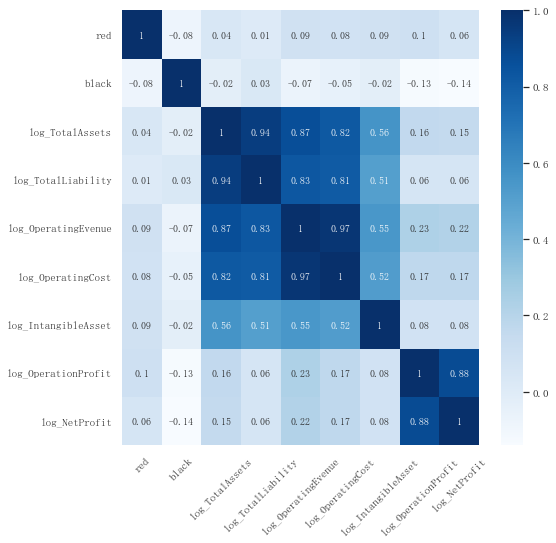

------------------------other_perf------------------------


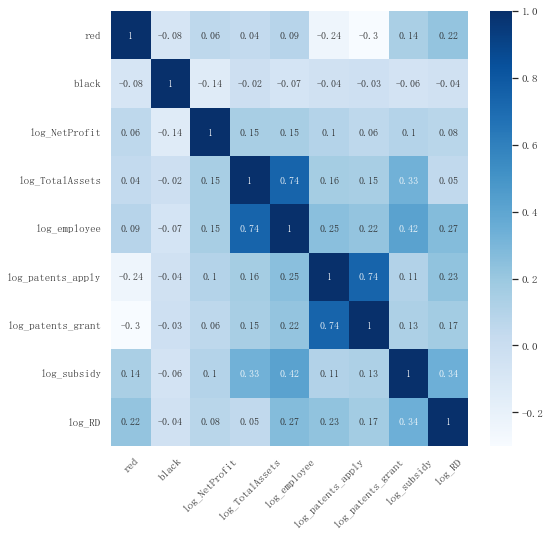

------------------------new_perf------------------------


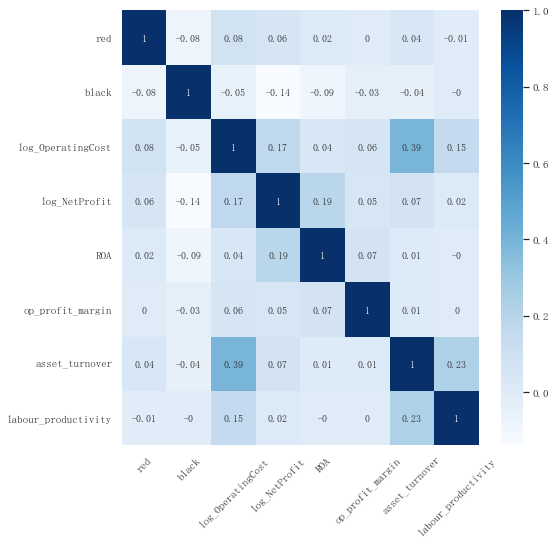

------------------------growth_perf------------------------


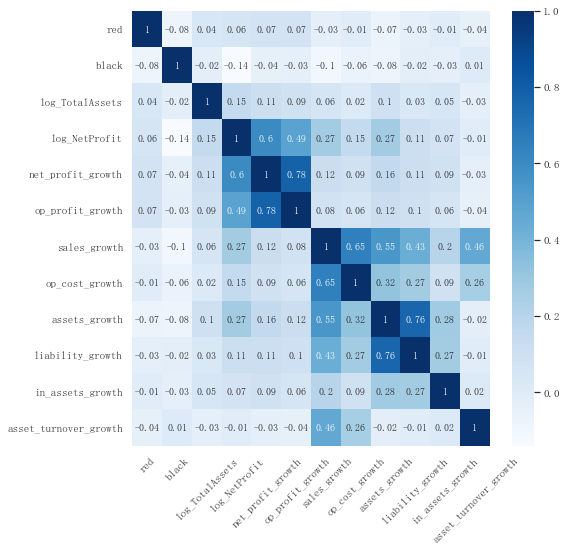

------------------------credit------------------------


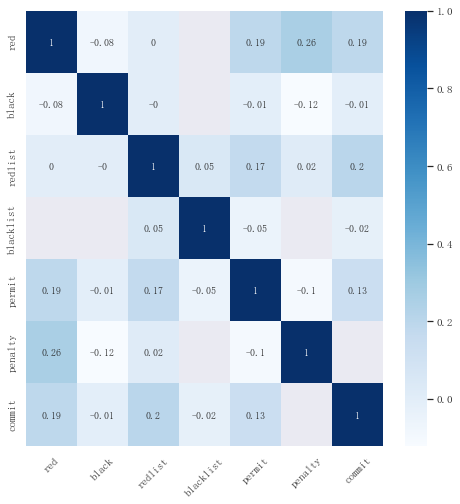

In [30]:

# data setup 
df_cpr = setup_regression_data(year_diff=1, with_relationship=True)
save_stata_data(df_cpr, 'panel_cpr.dta')


# correlation

In [33]:
# correlation of basic X
def show_corr(df):
    """
    Show correlation matrix.
    
    Parameters
    ----------
    df : DataFrame
        The regression data.
        
    Returns
    ----------
    DataFrame
    """
    corr_dict = {
        'log_performance': ['red', 'black',
                        'log_TotalAssets', 'log_TotalLiability', 'log_OperatingEvenue', 'log_OperatingCost', 'log_IntangibleAsset',
                         'log_OperationProfit', 'log_NetProfit', 
                        ],
        'other_perf': ['red', 'black',
                       'log_NetProfit', 'log_TotalAssets', 
                       'log_employee',
                       'log_patents_apply', 'log_patents_grant',
                       'log_subsidy', 'log_RD'                
                      ],
        'new_perf': ['red', 'black',
                        'log_NetProfit', 
                     'log_ROA', 'log_op_profit_margin', 'log_OperatingCost', 'log_asset_turnover', 'log_labour_productivity'
        ],

        'growth_perf': ['red', 'black',
                        'log_TotalAssets', 'log_NetProfit', 
                        'net_profit_growth', 'op_profit_growth',
                       'sales_growth', 'op_cost_growth', 'assets_growth',
                       'liability_growth', 'in_assets_growth', 'asset_turnover_growth' 
                        ],

        'credit': ['red', 'black',
                  'redlist', 'blacklist', 'permit', 'penalty', 'commit']
    }

    for key, col_list in corr_dict.items():
        print(f'------------------------{key}------------------------')
        
        df_corr = df[col_list].corr().round(2)

        #display(df_corr)
        plt.figure(figsize = (8,8))
        
        g = sns.heatmap(df_corr, annot=True, cmap='Blues')
        g.set_xticklabels(g.get_xticklabels(), rotation = 45)
        
        plt.savefig(os.path.join(stat_path, 'corr', key+'.png'))
        
        plt.show()
        

In [44]:
def power_analysis(): 
    """
    Perform statistical power analysis to check the minimum size of diffrent groups.
    """
    import statsmodels.api as sm
    from statsmodels.stats.power import TTestIndPower

    # Define your parameters
    effect_size = 0.5  # Adjust this based on your expected effect size
    alpha = 0.05       # Significance level
    power = 0.80       # Desired power level

    # Specify the sample size ratio relative to the first group
    sample_size_ratio = [1, 9323 / 12560, 94 / 12560]
    #sample_size_ratio = [1, 2796 / 3422, 59 / 3422]

    # Create an instance of the TTestIndPower class
    power_analysis = TTestIndPower()

    # Calculate the required sample sizes for each group
    sample_sizes = [power_analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power, ratio=ratio)
                    for ratio in sample_size_ratio]

    # Print the results
    for i, size in enumerate(sample_sizes):
        print(f"Required sample size for Group {i+1}: {size:.2f}")
        
#power_analysis()

Required sample size for Group 1: 63.77
Required sample size for Group 2: 74.81
Required sample size for Group 3: 4228.27


In [51]:
', '.join([c for c in df_cpr.columns])


'total_daughters, Affiliate, Joint Venture, Subsidiary, green_daughters, red_daughters, black_daughters, green-Affiliate, green-Joint Venture, green-Subsidiary, red-Affiliate, red-Joint Venture, red-Subsidiary, black-Affiliate, black-Joint Venture, black-Subsidiary, green, red, black, redlist, blacklist, watchlist, permit, penalty, commit, stock_code, employee, organ_type, organ_type_code, IndustryCode, IndustryName, province_con, LargestHolder, LargestHolderRate, patents_apply, patents_grant, subsidy, RD, TotalAssets, TotalLiability, IntangibleAsset, ProfitParent, NetProfit, OperatingEvenue, OperatingCost, OperationProfit, age, credit, real_subsidy, real_RD, real_TotalAssets, real_TotalLiability, real_IntangibleAsset, real_ProfitParent, real_NetProfit, real_OperatingEvenue, real_OperatingCost, real_OperationProfit, labour_productivity, ever_red, ever_black, ever_red_daughters, ever_black_daughters, ROA, op_profit_margin, asset_turnover, log_patents_apply, log_patents_grant, log_employ

In [47]:
df_cpr.columns.shape

(147,)

------------------------log_performance------------------------


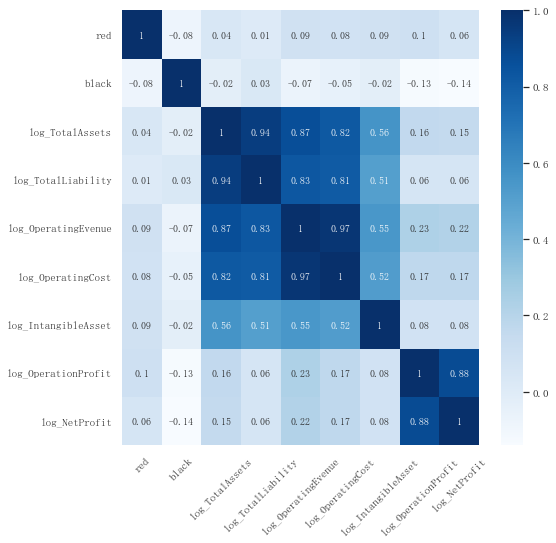

------------------------other_perf------------------------


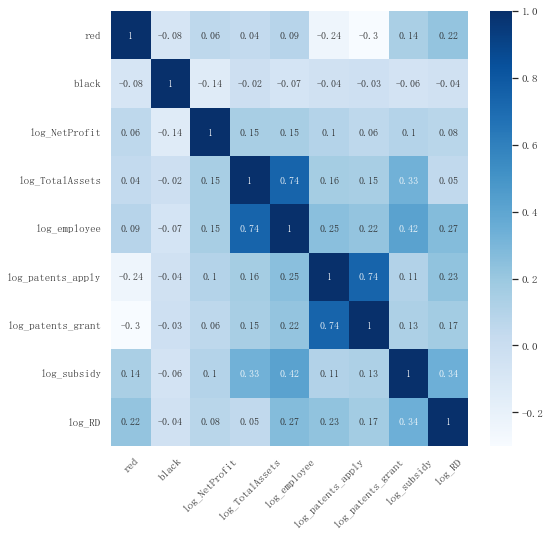

------------------------new_perf------------------------


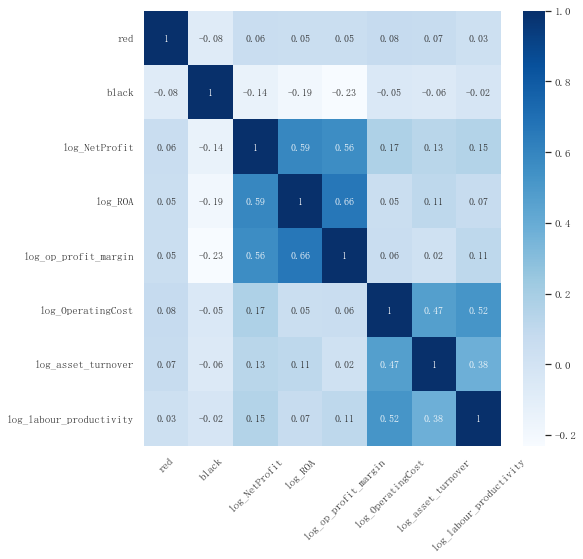

------------------------growth_perf------------------------


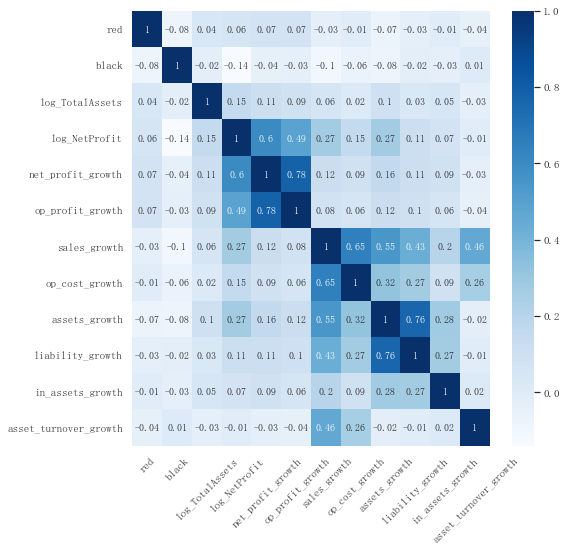

------------------------credit------------------------


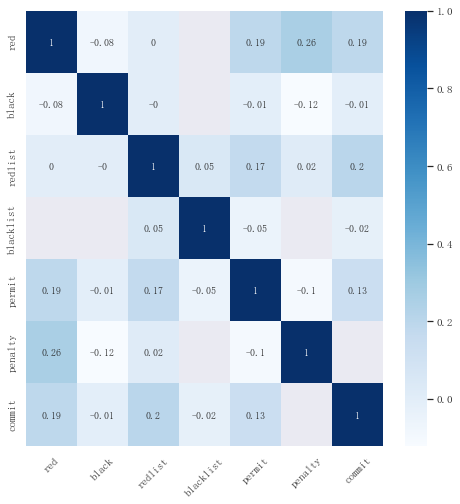

In [34]:
#show_corr(df_cpr)